# 6장 - 모델 평가와 하이퍼파라미터 튜닝의 모범 사례

In [1]:
from IPython.display import Image

# 파이프라인을 사용한 효율적인 워크플로

4장에서는 특성의 스케일을 조정하기 위해 표준화를 적용했고  
5장에서는 데이터 압축을 위해 주성분 분석을 적용했다.  
이때 테스트 데이터셋에 있는 별도의 샘플처럼 새로운 데이터의 스케일을 조정하고 압축하기 위해 훈련 데이터셋에서 학습한 파라미터를 재사용해야 한다고 배웠다.  
이를 위해 아주 유용하게 사용할 수 있는 사이킷런의 `Pipeline` 클래스를 배워보자.

## 위스콘신 유방암 데이터셋

이 장에서 위스콘신 유방암 데이터셋을 사용.  
여기에는 악성과 양성인 조양 세포 샘플 569개가 포함되어 있다.  
데이터셋의 첫 두 열에는 샘플의 고유 ID 번호와 진단 결과(M=악성, B=양성)rk emfdj dlTek.  
3번째에서 32번째까지 열에는 세포 핵의 디지털 이미지에서 계산된 30개의 실수 값 특성이 담겨 있다.  
이 특성을 사용하여 종양이 악성인지 양성인지 예측하는 모델을 만들 것이다. 

In [2]:
# 1. pandas를 사용하여 UCI 서버에서 직접 데이터셋을 읽어 들인다.
import pandas as pd

df = pd.read_csv('https://archive.ics.uci.edu/ml/'
                 'machine-learning-databases'
                 '/breast-cancer-wisconsin/wdbc.data', header=None)

# UCI 머신 러닝 저장소에서 유방암 데이터셋을 다운로드할 수 없을 때
# 다음 주석을 해제하고 로컬 경로에서 데이터셋을 적재하세요:

# df = pd.read_csv('wdbc.data', header=None)

df.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [3]:
df.shape

(569, 32)

In [4]:
# 2. 그 다음, 30개의 특성을 넘파이 배열 X에 할당한다. 
# LabelEncoder 객체를 사용하여 클래스 레이블을 원본 문자열 표현('M'과 'B')에서 정수로 변환한다. 
from sklearn.preprocessing import LabelEncoder

X = df.loc[:, 2:].values
y = df.loc[:, 1].values
le = LabelEncoder()
y = le.fit_transform(y)
le.classes_


array(['B', 'M'], dtype=object)

클래스 레이블(진단 결과)을 배열 y에 인코딩하면 악성(malignant) 종양은 클래스 1로 표현되고 양성(benign) 종양은 클래스 0으로 각각 표현된다. 

In [5]:
le.transform(['M', 'B'])

array([1, 0])

In [6]:
# 데이터셋을 훈련 데이터셋(전체 데이터의 80%)과 별도의 테스트 데이터셋(전체 데이터의 20%)으로 나눈다.
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, 
                     test_size=0.20,
                     stratify=y,
                     random_state=1)

## 파이프라인으로 변환기와 추정기 연결

많은 머신 러닝 알고리즘이 최적의 성능을 위해 입력 특성이 같은 스케일을 가져야 한다.  
위스콘신 유방암 데이터셋의 특성은 다양한 스케일로 측정되었기 때문에 로지스틱 회귀 같은 선형 분류기에 주입하기 전에 특성을 표준화해야 한다.  
여기서는 주성분 분석(PCA)을 통해 초기 30차원에서 좀 더 낮은 2차원 부분 공간으로 데이터를 압축한다고 가정.  

훈련 데이터셋과 테스트 데이터셋을 각각 학습하고 변환하는 단계를 구성하는 대신 StandardScaler, PCA, LogisticRegression 객체를 하나의 파이프라인으로 연결할 수 있다. 

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=2),
                        LogisticRegression(random_state=1))

pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
print('테스트 정확도: %.3f' % pipe_lr.score(X_test, y_test))

테스트 정확도: 0.956


`make_pipeline` 함수는 여러 개의 사이킷런 변환기(입력에 대해 `fit` 메서드와 `transform` 메서드를 지원하는 객체)와 그 뒤에 `fit` 메서드와 `predict` 메서드를 구현한 사이킷런 추정기를 연결할 수 있다. 

In [8]:
import matplotlib.pyplot as plt
from sklearn import set_config
set_config(display='diagram')
pipe_lr

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=2)),
                ('logisticregression', LogisticRegression(random_state=1))])

In [9]:
# 사이킷런의 파이프라인 작동 방식
Image(url='https://git.io/JtsTr', width=500) 

# K-겹 교차 검증을 사용한 모델 성능 평가

머신 러닝 모델을 구축하는 핵심 단계 중 하나는 처음 본 데이터에 대한 모델 성능을 추정하는 것이다.  
훈련 데이터셋에서 모델을 학습하고 같은 데이터로 새로운 데이터에 얼마나 잘 동작하는지 추정한다고 가정해보자.  
모델이 너무 간단하면 과소적합(높은 편향)이 문제가 되고 너무 복잡하면 훈련 데이터에 과대적합(높은 분산)될 수 있다.  

적절한 편향-분산 트레이드오프를 찾으려면 모델을 주의 깊게 평가해야 한다. 

## 홀드아웃 방법

전통적이고 널리 사용되는 머신 러닝 모델의 일반화 성능 추정 방법은 홀드아웃 교차 검증.  
홀드 아웃 방법은 초기 데이터셋을 별도의 훈련 데이터셋과 테스트 데이터셋으로 나눈다. 전자는 모델 훈련에 사용하고 후자는 일반화 성능을 추정하는 데 사용한다.  
일반적인 머신 러닝 애플리케이션에서는 처음 본 데이터에서 예측 성능을 높이기 위해 하이퍼파라미터를 튜닝하고 비교해야 한다. 이 과정을 모델 선택이라고 한다.  
모델 선택이란 이름은 주어진 분류 모델에서 튜닝할 파라미터(또는 하이퍼파라미터)의 최적 값을 선택해야 하는 것을 의미한다.  
모델 선택에 같은 테스트 데이터셋을 반복해서 재사용하면 훈련 데이터셋의 일부가 되는 셈이고 결국 모델은 과대적합될 것이다.  

모델 선택에 홀드아웃 방법을 사용하는 가장 좋은 방법은 데이터를 **훈련 데이터셋, 검증 데이터셋, 테스트 데이터셋 세 개의 부분으로 나누는 것**이다.  
훈련 데이터셋은 여러 가지 모델을 훈련하는 데 사용한다. 검증 데이터셋에 대한 성능은 모델 선택에 사용한다. 훈련과 모델 선택 단계에서 모델이 만나지 못한 테스트 데이터셋을 분리했기 때문에 새로운 데이터에 대한 일반화 능력을 덜 편향되게 추정할 수 있는 장점이 있다. 

In [10]:

Image(url='https://git.io/JtsTo', width=500) 

홀드아웃 방법은 훈련 데이터를 훈련 데이터셋과 검증 데이터셋으로 나누는 방법에 따라 성능 추정이 민감할 수 있다는 것이 단점이다.  
검증 데이터셋의 성능 추정이 어떤 샘플을 사용하는냐에 따라 달라질 것이다.

## K-겹 교차 검증

K-겹 교차 검증에서는 중복을 허용하지 않고 훈련 데이터셋을 k개의 폴드(fold)로 랜덤하게 나눈다.  
K-1개의 폴드로 모델을 훈련하고 나머지 하나의 폴드로 성능을 평가한다. 이 과정을 k번 반복하여 k개의 모델과 성능 추정을 얻는다. 
그 다음 서로 다른 독립적인 폴드에서 얻은 성능 추정을 기반으로 모델의 평균 성능을 계산한다.  
*홀드아웃 방법에 비해 훈련 데이터셋의 분할에 덜 민감한 성능 추정을 얻을 수 있다.* 즉, 테스트 데이터셋에서 모델의 성능을 평가할 때 만족할 만한 일반화 성능을 내는 최적의 하이퍼파라미터 값을 찾기 위해 사용한다.  

만족스러운 하이퍼파라미터 값을 찾은 후에는 전체 훈련 데이터셋을 사용하여 모델을 다시 훈련한다. 그다음 독립적인 테스트 데이터셋을 사용하여 최종 성능을 추정한다.  
K-겹 교차 검증 후에 전체 훈현 데이터셋으로 모델을 학습하는 이유는 훈련 샘플이 많을수록 학습 알고리즘이 더 정확하고 안정적인 모델을 만들기 때문이다.  

K-겹 교차 검증이 중복을 허용하지 않는 리샘플링 기법이기 때문에 **모든 샘플 포인트가 훈련하는 동안 검증에 딱 한 번 사용되는 장점**이 있다.  
이로 인해 홀드아웃 방법보다 모델 성능의 추정에 분산이 낮다. 

In [11]:

Image(url='https://git.io/JtsT6', width=500) 

경험적으로 보았을 때 K-겹 교차 검증에서 좋은 기본값은 k=10이다. 예를 들어 론 코하비(Ron Kohavi)는 여러 종류의 실제 데이터셋에서 수행한 실험을 통해 10-겹 교차 검증이 가장 뛰어난 편향-분산 트레이드오프를 가진다고 제안했다.  

***비교적 작은 훈련 데이터셋으로 작업한다면 폴드 개수를 늘리는 것이 좋다.*** k 값이 증가하면 더 많은 훈련 데이터가 각 반복에 사용되고 모델 성능을 평균하여 일반화 성능을 추정할 때 더 낮은 편향을 만든다.  
k 값이 아주 크면 교차 검증 알고리즘의 실행 시간이 늘어나고 분산이 높은 추정을 만든다. 이는 훈련 폴드가 서로 많이 비슷해지기 때문이다.  

기본 k-겹 교차 검증방법보다 좀 더 향상된 방법은 **계층적 k-겹 교차 검증(stratified K-fold cross-validation)**이다. 좀 더 나은 편향과 분산 추정을 만든다. 특히 ***클래스 비율이 동등하지 않을 때***이다.  
계층적 교차 검증은 각 폴드에서 클래스 비율이 전체 훈련 데이터셋에 있는 클래스 비율을 대표하도록 유지한다. 

In [12]:
import numpy as np
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=10).split(X_train, y_train)

scores = []
for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    print('폴드: %2d, 클래스 분포: %s, 정확도: %.3f' % (k+1,
            np.bincount(y_train[train]), score))

print('\nCV 정확도: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

폴드:  1, 클래스 분포: [256 153], 정확도: 0.935
폴드:  2, 클래스 분포: [256 153], 정확도: 0.935
폴드:  3, 클래스 분포: [256 153], 정확도: 0.957
폴드:  4, 클래스 분포: [256 153], 정확도: 0.957
폴드:  5, 클래스 분포: [256 153], 정확도: 0.935
폴드:  6, 클래스 분포: [257 153], 정확도: 0.956
폴드:  7, 클래스 분포: [257 153], 정확도: 0.978
폴드:  8, 클래스 분포: [257 153], 정확도: 0.933
폴드:  9, 클래스 분포: [257 153], 정확도: 0.956
폴드: 10, 클래스 분포: [257 153], 정확도: 0.956

CV 정확도: 0.950 +/- 0.014


In [13]:
# 좀 더 간단하게 계층별 K-겹 교차 검증을 사용하여 모델을 평가
from sklearn.model_selection import cross_val_score

scores = cross_val_score(estimator=pipe_lr,
                         X=X_train,
                         y=y_train,
                         cv=10,
                         n_jobs=1)
print('CV 정확도 점수: %s' % scores)
print('CV 정확도: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV 정확도 점수: [0.93478261 0.93478261 0.95652174 0.95652174 0.93478261 0.95555556
 0.97777778 0.93333333 0.95555556 0.95555556]
CV 정확도: 0.950 +/- 0.014


### Note
`cross_val_score` 함수가 검증에 사용하는 기본 측정 지표는 회귀일 때는 $R^2$, 분류일 때는 정확도이다.  
scoring 매개변수를 사용하여 다른 지표로 바꿀 수 있다. 

In [14]:
from sklearn.model_selection import cross_validate

scores = cross_validate(estimator=pipe_lr, 
                        X=X_train, 
                        y=y_train, 
                        scoring=['accuracy'], 
                        cv=10, 
                        n_jobs=-1)
print('CV 정확도 점수: %s' % scores['test_accuracy'])
print('CV 정확도: %.3f +/- %.3f' % (np.mean(scores['test_accuracy']), 
                                 np.std(scores['test_accuracy'])))

CV 정확도 점수: [0.93478261 0.93478261 0.95652174 0.95652174 0.93478261 0.95555556
 0.97777778 0.93333333 0.95555556 0.95555556]
CV 정확도: 0.950 +/- 0.014


`cross_val_predict` 함수는 `cross_val_score와` 비슷한 인터페이스를 제공하지만 훈련 데이터셋의 각 샘플이 테스트 폴드가 되었을 때 만들어진 예측을 반환한다.  
따라서 `cross_val_predict` 함수의 결과를 사용하여 모델의 성능을 계산하면 `cross_val_score` 함수의 결과와 다르며 바람직한 일반화 성능 추정이 아니다.  
`cross_val_predict` 함수는 훈련 데이터셋에 대한 예측 결과를 시각화하거나 스태킹(Stacking) 앙상블(Ensemble) 방법처럼 다른 모델에 주입할 훈련 데이터를 만들기 위해 사용할 수 있다. 

In [15]:
from sklearn.model_selection import cross_val_predict

preds = cross_val_predict(estimator=pipe_lr,
                          X=X_train, 
                          y=y_train,
                          cv=10, 
                          n_jobs=-1)
preds[:10]

array([0, 0, 0, 0, 0, 0, 0, 1, 1, 1])

# 학습 곡선과 검증 곡선을 사용한 알고리즘 디버깅

## 학습 곡선으로 편향과 분산 문제 분석

주어진 훈련 데이터셋에 비해 모델이 너무 복잡하면, 즉 모델의 자유도나 모델 파라미터가 너무 많으면 모델이 훈련 데이터에 과대적합되고 처음 본 데이터에 잘 일반화되지 못하는 경향이 있다.  
**보통 훈련 샘플을 더 모으면 과대적합을 줄이는 데 도움이 된다.**  

하지만 실전에서는 데이터를 더 모으는 것이 매우 비싸거나 그냥 불가능할 때도 많다.  
모델의 훈련 정확도와 검증 정확도를 훈련 데이터셋의 크기 함수로 그래프를 그려 보면 모델에 높은 분산의 문제가 있는지 높은 편향의 문제가 있는지 쉽게 감지할 수 있다. 더 많은 데이터를 모으는 것이 문제를 해결할 수 있을지 판단이 가능해진다. 

In [16]:
Image(url='https://git.io/JtsTi', width=600) 

왼쪽 위 그래프는 편향이 높은 모델을 보여준다. 이 모델은 훈련 정확도와 교차 검증 정확도가 모두 낮다. 훈련 데이터에 과소적합되었다는 것을 나타낸다.  
이 문제를 해결하는 일반적인 방법은 모델의 파라미터 개수를 늘리는 것이다. 예를 들어 추가적인 특성을 수집하거나 만든다. 또는 서포트 벡터 머신(SVM)이나 로지스틱 회귀 분류기에서 규제 강도를 줄인다.  

오른쪽 위 그래프는 분산이 높은 모델을 보여준다. 훈련 정확도와 교차 검증 사이에 큰 차이가 있다는 것을 나타난다.  
과대적합 문제를 해결하려면 더 많은 훈련 데이터를 모으거나 모델 복잡도를 낮추거나 규제를 증가시킬 수 있다. 규제가 없는 모델에서는 특성 선택이나 특성 추출을 통해 특성 개수를 줄여 과대적합을 감소할 수 있다.  
더 많은 훈련 데이터를 수집하는 것이 보통 과대적합의 가능성을 줄이지만 항상 도움이 되는 것은 아니다. 

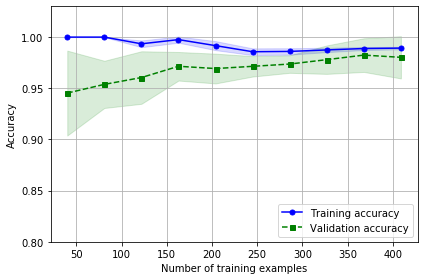

In [17]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve


pipe_lr = make_pipeline(StandardScaler(),
                        LogisticRegression(penalty='l2', random_state=1,
                                           max_iter=10000))

train_sizes, train_scores, test_scores =\
                learning_curve(estimator=pipe_lr,
                               X=X_train,
                               y=y_train,
                               train_sizes=np.linspace(0.1, 1.0, 10),
                               cv=10,
                               n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.tight_layout()
# plt.savefig('images/06_05.png', dpi=300)
plt.show()

모델의 훈련에 250개의 샘플 이상을 사용할 때 훈련과 검증 데이터셋에서 잘 작동한다.  
후련 데이터셋이 250개 샘플보다 줄어들면 훈련 정확도가 증가하면서 훈련 정확도와 검증 정확도 사이의 차이는 넓어진다. 이는 과대적합이 증가한다는 증거이다.

## 검증 곡선으로 과대적합 과소적합 조사

검증 곡선은 **과대적합과 과소적합 문제를 해결하여 모델 성능을 높일 수 있는 유용한 도구**이다.  
검증 곡선은 학습 곡선과 관련이 있지만 샘플 크기의 함수로 훈련 정확도와 테스트 정확도를 그리는 대신 모델 파라미터 값의 함수로 그린다. 

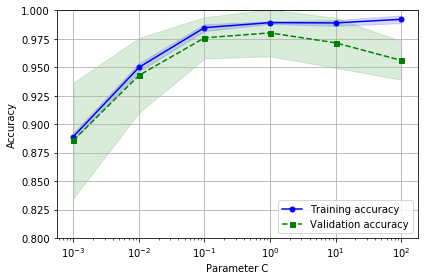

In [18]:
from sklearn.model_selection import validation_curve


param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, test_scores = validation_curve(
                estimator=pipe_lr, 
                X=X_train, 
                y=y_train, 
                param_name='logisticregression__C', 
                param_range=param_range,
                cv=10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, 
         color='blue', marker='o', 
         markersize=5, label='Training accuracy')

plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='blue')

plt.plot(param_range, test_mean, 
         color='green', linestyle='--', 
         marker='s', markersize=5, 
         label='Validation accuracy')

plt.fill_between(param_range, 
                 test_mean + test_std,
                 test_mean - test_std, 
                 alpha=0.15, color='green')

plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.0])
plt.tight_layout()
# plt.savefig('images/06_06.png', dpi=300)
plt.show()

C 값이 바꾸미에 따라 정확도 차이가 미묘하지만 규제 강도를 높이면(C 값을 줄이면) 모델이 데이터에 조금 과소적합되는 것을 볼 수 있다.  
규제 강도가 낮아지는 큰 C 값에서는 모델이 데이터에 조금 과대적합되는 경향을 보인다. 이 경우에 적절한 C 값은 0.01과 0.1 사이이다. 

# 그리드 서치를 사용한 머신 러닝 모델 세부 튜닝

머신 러닝에는 두 종류의 파라미터가 있다.  
하나는 훈련 데이터에서 학습되는 파라미터이다. 예를 들어 로지스틱 회귀의 가중치이다.  

다른 하나는 별도로 최적화되는 학습 알고리즘의 파라미터이다.  
후자는 모델의 튜닝 파라미터이고, 하이퍼파라미터라고도 불른다. 예를 들어 로지스틱 회귀의 규제 매개변수나 결정 트리의 깊이 매개변수이다. 

## 그리드 서치를 사용한 하이퍼파라미터 튜닝

리스트로 지정된 여러 가지 하이퍼파라미터 값 전체를 모두 조사한다.  
이 리스트에 있는 값의 모든 조합에 대해 모델 성능을 평가하여 최적의 조합을 찾는다. 

In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

pipe_svc = make_pipeline(StandardScaler(),
                         SVC(random_state=1))

param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

param_grid = [{'svc__C': param_range, 
               'svc__kernel': ['linear']},
              {'svc__C': param_range, 
               'svc__gamma': param_range, 
               'svc__kernel': ['rbf']}]

gs = GridSearchCV(estimator=pipe_svc, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  refit=True,
                  cv=10,
                  n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9846859903381642
{'svc__C': 100.0, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}


In [20]:
clf = gs.best_estimator_

# refit=True로 지정했기 때문에 다시 fit() 메서드를 호출할 필요가 없습니다.
# clf.fit(X_train, y_train)

print('테스트 정확도: %.3f' % clf.score(X_test, y_test))

테스트 정확도: 0.974


### Note
`GridSearchCV` 클래스와 `cross_validate` 함수에서 `return_train_score` 매개변수를 `True로` 지정하면 훈련 폴드에 대한 점수를 계산하여 반환한다.  
훈련 데이터셋에 대한 점수를 보고 과대적합과 과소적합에 대한 정보를 얻을 수 있지만 실행 시간이 오래 걸릴 수 있다.  
`param_range에` 여덟 개의 값이 지정되어 있기 때문에 `SVC` 모델은 `'linear'` 커널에 대해 8번, `'rbf'` 커널에 대해 64번 교차 검증이 수행된다. 따라서 훈련 폴드마다 반환되는 점수는 총 72개이다.  
이 값은 `GridSearchCV` 클래스의 `cv_results_` 딕셔너리 속성에 `split{폴드번호}_train_score` 와 같은 키에 저장되어 있다. 

In [21]:
gs = GridSearchCV(estimator=pipe_svc, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  cv=10,
                  return_train_score=True,
                  n_jobs=-1)
gs = gs.fit(X_train, y_train)

In [22]:
gs.cv_results_['split0_train_score']

array([0.6405868 , 0.93643032, 0.97555012, 0.98777506, 0.98533007,
       0.99266504, 0.99755501, 1.        , 0.62591687, 0.62591687,
       0.62591687, 0.62591687, 0.62591687, 0.62591687, 0.62591687,
       0.62591687, 0.62591687, 0.62591687, 0.62591687, 0.62591687,
       0.62591687, 0.62591687, 0.62591687, 0.62591687, 0.62591687,
       0.62591687, 0.62591687, 0.62591687, 0.62591687, 0.62591687,
       0.62591687, 0.62591687, 0.62591687, 0.7799511 , 0.94621027,
       0.96577017, 0.62591687, 0.62591687, 0.62591687, 0.62591687,
       0.78484108, 0.94621027, 0.9804401 , 0.99266504, 1.        ,
       1.        , 1.        , 1.        , 0.94621027, 0.97799511,
       0.99266504, 1.        , 1.        , 1.        , 1.        ,
       1.        , 0.97799511, 0.98777506, 0.99511002, 1.        ,
       1.        , 1.        , 1.        , 1.        , 0.98533007,
       0.99266504, 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        ])

In [23]:
# 전체 훈련 점수의 평균 값은 'mean_train_score' 키에 저장
gs.cv_results_['mean_train_score']

array([0.6402928 , 0.93724074, 0.97240801, 0.98510406, 0.98803447,
       0.99145447, 0.99707019, 0.9992677 , 0.62637307, 0.62637307,
       0.62637307, 0.62637307, 0.62637307, 0.62637307, 0.62637307,
       0.62637307, 0.62637307, 0.62637307, 0.62637307, 0.62637307,
       0.62637307, 0.62637307, 0.62637307, 0.62637307, 0.62637307,
       0.62637307, 0.62637307, 0.62637307, 0.62637307, 0.62637307,
       0.62637307, 0.62637307, 0.62637307, 0.77070249, 0.94700817,
       0.97167094, 0.62637307, 0.62637307, 0.62637307, 0.62637307,
       0.77949371, 0.94725326, 0.97704753, 0.99291848, 1.        ,
       1.        , 1.        , 1.        , 0.94652096, 0.97753354,
       0.99023257, 1.        , 1.        , 1.        , 1.        ,
       1.        , 0.97680064, 0.98852287, 0.99755799, 1.        ,
       1.        , 1.        , 1.        , 1.        , 0.98803387,
       0.99291848, 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        ])

In [24]:
# 비슷하게 첫 번째 폴드에 대한 테스트 점수는 'split0_test_score' 키에 저장.
gs.cv_results_['split0_test_score']

array([0.63043478, 0.89130435, 0.95652174, 0.97826087, 0.95652174,
       0.93478261, 0.95652174, 0.93478261, 0.63043478, 0.63043478,
       0.63043478, 0.63043478, 0.63043478, 0.63043478, 0.63043478,
       0.63043478, 0.63043478, 0.63043478, 0.63043478, 0.63043478,
       0.63043478, 0.63043478, 0.63043478, 0.63043478, 0.63043478,
       0.63043478, 0.63043478, 0.63043478, 0.63043478, 0.63043478,
       0.63043478, 0.63043478, 0.63043478, 0.69565217, 0.93478261,
       0.95652174, 0.63043478, 0.63043478, 0.63043478, 0.63043478,
       0.69565217, 0.93478261, 0.93478261, 1.        , 0.63043478,
       0.63043478, 0.63043478, 0.63043478, 0.93478261, 0.97826087,
       1.        , 1.        , 0.63043478, 0.63043478, 0.63043478,
       0.63043478, 0.97826087, 0.97826087, 0.97826087, 1.        ,
       0.63043478, 0.63043478, 0.63043478, 0.63043478, 0.97826087,
       0.95652174, 0.95652174, 1.        , 0.63043478, 0.63043478,
       0.63043478, 0.63043478])

In [25]:
# GridSearchCV 클래스의 객체에서도 최종 모델의 score, predict, transform 메서드를 바로 호출할 수 있다.
print('테스트 정확도: %.3f' % gs.score(X_test, y_test))

테스트 정확도: 0.974


### Note
그리그 서치가 최적의 매개변수 조합을 찾을 수 있는 강력한 도구이지만 가능한 모든 매개변수 조합을 평가하기 위해 계산 비용이 매우 많이 든다.  
사이킷런에는 여러 가지 매개변수 조합을 샘플링하는 다른 방법으로 랜덤 서치(randomized search)가 있다.  

랜덤 서치는 일반적으로 그리드 서치와 비슷한 성능을 내지만 훨씬 비용과 시간이 적게 든다.

In [26]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils.fixes import loguniform

distribution =  loguniform(0.0001, 1000.0)

param_dist = [{'svc__C': distribution, 
               'svc__kernel': ['linear']},
              {'svc__C': distribution, 
               'svc__gamma': distribution, 
               'svc__kernel': ['rbf']}]

rs = RandomizedSearchCV(estimator=pipe_svc,
                        param_distributions=param_dist,
                        n_iter=30,
                        cv=10,
                        random_state=1,
                        n_jobs=-1)
rs = rs.fit(X_train, y_train)
print(rs.best_score_)
print(rs.best_params_)

0.9824637681159419
{'svc__C': 210.6644070836221, 'svc__gamma': 0.0006861724481510375, 'svc__kernel': 'rbf'}


사이킷런 0.24 버전에서 추가된 `HalvingGridSearchCV`는 모든 파라미터 조합에 대해 제한된 자원으로 실행한 후 가장 좋은 후보를 골라서 더 많은 자원을 투여하는 식으로 반복적으로 탐색을 수행.  
`HalvingGridSearchCV`의 `resource` 매개변수는 반복마다 늘려 갈 자원을 정의한다. 

In [27]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
hgs = HalvingGridSearchCV(
    estimator=pipe_svc,
    param_grid=param_grid,
    cv=10,
    n_jobs=-1, verbose=1)

hgs = hgs.fit(X_train, y_train)
print(hgs.best_score_)
print(hgs.best_params_)

n_iterations: 3
n_required_iterations: 4
n_possible_iterations: 3
min_resources_: 40
max_resources_: 455
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 72
n_resources: 40
Fitting 10 folds for each of 72 candidates, totalling 720 fits
----------
iter: 1
n_candidates: 24
n_resources: 120
Fitting 10 folds for each of 24 candidates, totalling 240 fits
----------
iter: 2
n_candidates: 8
n_resources: 360
Fitting 10 folds for each of 8 candidates, totalling 80 fits
0.9803174603174604
{'svc__C': 10.0, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}


## 중첩 교차 검증을 사용한 알고리즘 선택

**여러 종류의 머신 러닝 알고리즘을 비교**하려면 중첩 교차 검증(nested cross-validation)방법이 권장된다.  

In [28]:
Image(url='https://git.io/JtsTP', width=500) 

중첩 교차 검증은 바깥쪽 K-겹 교차 검증 루프가 데이터를 훈련 폴드와 테스트 폴드로 나누고 안쪽 루프가 훈련 폴드에서 K-겹 교차 검증을 수행하여 모델을 선택한다.  
모델이 선택되면 테스트 폴드를 사용하여 모델 성능을 평가한다.  

이런 방식은 계산 성능이 중요한 **대용량 데이터셋에서 유용**하다.

In [29]:
gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=2)

scores = cross_val_score(gs, X_train, y_train, 
                         scoring='accuracy', cv=5)
print('CV 정확도: %.3f +/- %.3f' % (np.mean(scores),
                                      np.std(scores)))

CV 정확도: 0.974 +/- 0.015


변환된 평균 교차 검증 점수는 모델의 하이퍼파라미터를 튜닝했을 때 처음 본 데이터에서 기대할 수 있는 추정값이 된다.   

예를 들어 중첩 교차 검증을 사용하여 SVM 모델과 단일 결정 트리 분류기를 비교할 수 있다.  
간단한 예를 위해 `max_depth` 매개변수만 튜닝해보자.

In [30]:
from sklearn.tree import DecisionTreeClassifier

gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=0),
                  param_grid=[{'max_depth': [1, 2, 3, 4, 5, 6, 7, None]}],
                  scoring='accuracy',
                  cv=2)

scores = cross_val_score(gs, X_train, y_train, 
                         scoring='accuracy', cv=5)
print('CV 정확도: %.3f +/- %.3f' % (np.mean(scores), 
                                      np.std(scores)))

CV 정확도: 0.934 +/- 0.016


결과에서 알 수 있듯이 SVM 모델 중첩 교차 검증 성능(97.4%)은 결정 트리의 성능(93.4%)보다 훨씬 뛰어나다.  
이 데이터셋과 동일 분포에서 발생되는 새로운 데이터를 분류하기 위해서는 SVM이 더 좋은 선택일 것이다.

# 여러 가지 성능 평가 지표

## 오차 행렬

In [31]:
Image(url='https://git.io/JtsT1', width=300) 

오차 행렬은 위의 그림과 같이 **진짜 양성**(True Positive, TP), **진짜 음성**(True Negative, TN), **거짓 양성**(False Positive, FP), **거짓 음성**(False Negative, FN)의 개수를 적은 단순한 정방 행령이다.

In [32]:
from sklearn.metrics import confusion_matrix

pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[71  1]
 [ 2 40]]


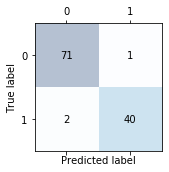

In [33]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
# plt.savefig('images/06_09.png', dpi=300)
plt.show()

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


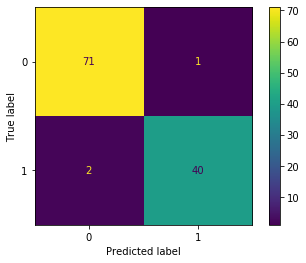

In [34]:
# 사이킷런 0.22 버전에서 추가된 plot_confusion_matrix() 함수를 사용하면 오차 행렬을 쉽게 그릴 수 있다.
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(pipe_svc, X_test, y_test)
# plt.savefig('images/06_plot_confusion_matrix.png', dpi=300)
plt.show()

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


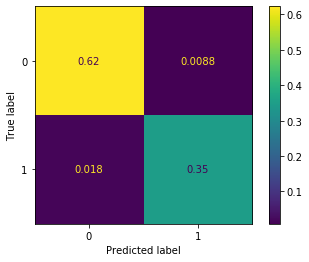

In [35]:
# normalize 매개변수를 사용하여 오차 행렬의 값을 정규화할 수 있다.
plot_confusion_matrix(pipe_svc, X_test, y_test, 
                      normalize='all')
# plt.savefig('images/06_plot_confusion_matrix_normalize.png', dpi=300)
plt.show()

## 분류 모델의 정밀도와 재현율 최적화

예측 오차(ERR)와 정확도(ACC) 모두 *얼마나 많은 샘플을 잘못 분류했는지 알반적인 정보를 알려준다.*  
오차는 잘못된 예측의 합을 전체 예측 샘플 개수로 나눈 것이다. 정확도는 옳은 예측의 합을 전체 예측 샘플 개수로 나누어 계산한다.  
$$ERR={FP+FN \over FP+FN+TP+TN}$$  

예측 정확도는 오차에서 바로 계산할 수 있다.  
$$ACC = {TP+TN \over FP+FN+TP+TN} = 1-ERR$$  

**진짜 양성 비율**(True Positive Rate, TPR)과 **거짓 양성 비율**(False Positive Rate, FPR)은 ***클래스 비율이 다른 경우 유용한 성능 지표***이다.  
$$FPR = {FP \over N} = {FP \over FP+TN}$$  
$$TPR = {TP \over P} = {TP \over FN+TP}$$  

종양 진단 문제에서는 환자가 적절한 치료를 받을 수 있도록 악성 종양을 감지하는 데 관심이 있다. 또 불필요하게 환자에게 걱정을 끼치지 않도록 음성 조양이 악성으로 분류되는 경우(FP)를 줄이는 것이 중요하다.  
FPR에 비해서 TPR은 전체 양성 샘플(P) 중에서 올바르게 분류된 양성 샘플의 비율을 알려준다.  

정확도(PRE)와 재현율(REC) 성능 지표는 진짜 양성과 진짜 음성 샘플의 비율과 관련이 있다. 사실 REC는 TPR의 다른 이름이다.  
$$PRE = {TP \over TP+FP}$$  
$$REC = TPR = {TP \over P} = {TP \over FN+TP}$$  

</br></br>  
악성 종양 감지 문제에서 재현율을 최적화하면 악성 종양을 감지하지 못할 확률은 최소화하는 데 도움이 된다. 하지만 건강한 환자임에도 악성 종양으로 예측하는 비용이 발생한다.(높은 FP때문)  
반대로 정밀도를 최적화하면 환자가 악성 종양을 가졌는지 정확히 예측하게 된다. 하지만 악성 종양 환자를 자주 놓치는 결과를 초래한다.(높은 FN떄문)  

PRE와 REC 최적화로 인한 장단점의 균형을 맞추기 위해 PRE와 REC를 조합한 F1-점수를 자주 사용한다.  
$$F1 = 2{{PRE \times REC} \over {PRE+REC}}$$

In [36]:
from sklearn.metrics import precision_score, recall_score, f1_score

print('정밀도: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
print('재현율: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

정밀도: 0.976
재현율: 0.952
F1: 0.964


In [37]:
# 또한, GridSearchCVdml scoring 매개변수를 사용하여 정확도 대신 다른 성능 지표를 사용할 수 있다.
from sklearn.metrics import make_scorer

scorer = make_scorer(f1_score, pos_label=0)

c_gamma_range = [0.01, 0.1, 1.0, 10.0]

param_grid = [{'svc__C': c_gamma_range,
               'svc__kernel': ['linear']},
              {'svc__C': c_gamma_range,
               'svc__gamma': c_gamma_range,
               'svc__kernel': ['rbf']}]

gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring=scorer,
                  cv=10,
                  n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9861994953378878
{'svc__C': 10.0, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}


## ROC곡선 그리기

ROC(Receiver Operating Characteristic) 그래프는 분류기의 임계 값을 바꾸어 가며 계산된 FPR과 TPR 점수를 기반으로 분류 모델을 선택하는 유용한 도구이다.  
ROC 그래프의 대각선은 랜덤 추측으로 해석할 수 있고 대각선 아래에 위치한 분류 모델은 랜덤 추측보다 나쁜 셈이다.  
완벽한 분류기의 그래프는 TPR이 1이고 FPR이 0인 외쪽 위 구석에 위치한다.  

ROC 곡선의 아래 면적인 ROC AUC(ROC Area Under the Curve)를 계산하여 분류 모델의 성능을 종합할 수 있다.

/var/folders/tb/x7hcv5j94gn9b46c7qc1vfth0000gn/T/ipykernel_32630/3539133643.py:6: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if scipy_version >= Version('1.4.1'):


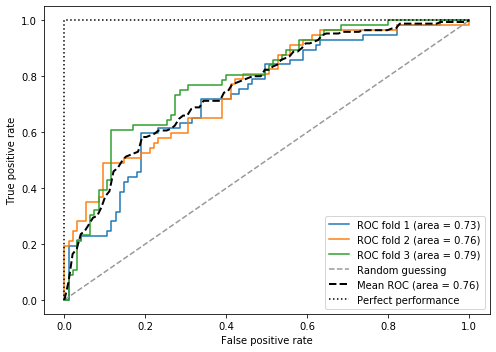

In [38]:
from sklearn.metrics import roc_curve, auc
from distutils.version import LooseVersion as Version
from scipy import __version__ as scipy_version


if scipy_version >= Version('1.4.1'):
    from numpy import interp
else:
    from scipy import interp


pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=2),
                        LogisticRegression(penalty='l2', 
                                           random_state=1,
                                           C=100.0))

X_train2 = X_train[:, [4, 14]]
    

cv = list(StratifiedKFold(n_splits=3).split(X_train, y_train))

fig = plt.figure(figsize=(7, 5))

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)

for i, (train, test) in enumerate(cv):
    probas = pipe_lr.fit(X_train2[train],
                         y_train[train]).predict_proba(X_train2[test])

    fpr, tpr, thresholds = roc_curve(y_train[test],
                                     probas[:, 1],
                                     pos_label=1)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr,
             tpr,
             label='ROC fold %d (area = %0.2f)'
                   % (i+1, roc_auc))

plt.plot([0, 1],
         [0, 1],
         linestyle='--',
         color=(0.6, 0.6, 0.6),
         label='Random guessing')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)
plt.plot([0, 0, 1],
         [0, 1, 1],
         linestyle=':',
         color='black',
         label='Perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")

plt.tight_layout()
# plt.savefig('images/06_10.png', dpi=300)
plt.show()

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be remov

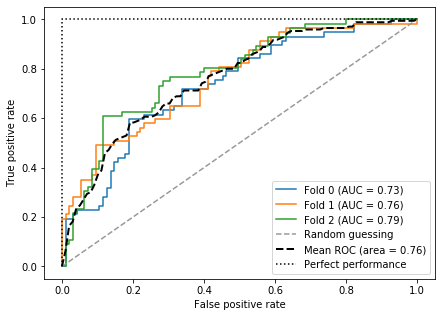

In [39]:
# 사이킷런 0.22 버전에서 plot_roc_curve() 함수와 plot_precesion_recall_curve() 함수를 사용하면 ROC 곡선과 정밀도-재현율 곡선을 쉽게 그릴 수 있다.
from sklearn.metrics import plot_roc_curve

fig, ax = plt.subplots(figsize=(7, 5))

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)

for i, (train, test) in enumerate(cv):
    pipe_lr.fit(X_train2[train], y_train[train])
    roc_disp = plot_roc_curve(pipe_lr, 
                              X_train2[test], y_train[test], 
                              name=f'Fold {i}', ax=ax)
    mean_tpr += interp(mean_fpr, roc_disp.fpr, roc_disp.tpr)
    mean_tpr[0] = 0.0

plt.plot([0, 1], [0, 1],
         linestyle='--', color=(0.6, 0.6, 0.6),
         label='Random guessing')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)

plt.plot([0, 0, 1], [0, 1, 1],
         linestyle=':', color='black',
         label='Perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")
# plt.savefig('images/06_plot_roc_curve.png', dpi=300)
plt.show()

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed i

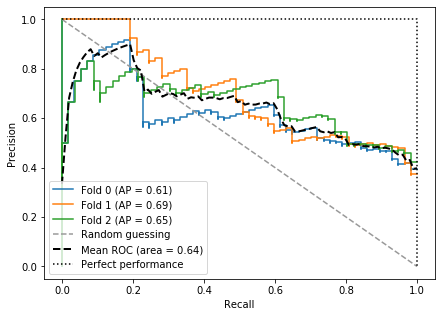

In [40]:
from sklearn.metrics import plot_precision_recall_curve

fig, ax = plt.subplots(figsize=(7, 5))

mean_precision = 0.0
mean_recall = np.linspace(0, 1, 100)

for i, (train, test) in enumerate(cv):
    pipe_lr.fit(X_train2[train], y_train[train])
    pr_disp = plot_precision_recall_curve(
        pipe_lr, X_train2[test], y_train[test], 
        name=f'Fold {i}', ax=ax)
    mean_precision += interp(mean_recall, pr_disp.recall[::-1], 
                             pr_disp.precision[::-1])

plt.plot([0, 1], [1, 0],
         linestyle='--', color=(0.6, 0.6, 0.6),
         label='Random guessing')

mean_precision /= len(cv)
mean_auc = auc(mean_recall, mean_precision)
plt.plot(mean_recall, mean_precision, 'k--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)

plt.plot([0, 1, 1], [1, 1, 0],
         linestyle=':', color='black',
         label='Perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc="lower left")
# plt.savefig('images/06_plot_precision_recall_curve.png', dpi=300)
plt.show()

이 절에서 언급한 성능 지표는 이진 분류에 대한 것이다. 사이킷런은 이런 평균 지표에 **마크로**(macro)와 **마이크로**(micro) 평균 방식을 구현하여 OvA(One-versus-All) 방식을 사용하는 다중 분류로 확장한다.  
마이크로 평균은 클래스별로 TP, TN, FP, FN을 계산한다.  
예를 들어 k개의 클래스가 있는 경우 정밀도의 마이크로 평균은 다음과 같이 계산한다.  
$$PRE_{mirco}={{TP_{1}+ \cdots + TP_{k}} \over {TP{1}+ \cdots + TP_{k}+FP_{1}+ \cdots +FP_{k}}}$$  

마크로 평균은 단순하게 클래스별 정밀도의 평균이다.  
$$PRE_{macro} = {{PRE_{1}+ \cdots + PRE_{k}} \over k}$$  

마이크로 평균은 각 샘플이나 예측에 동일한 가중치를 부여하고자 할 때 사용한다. 마크로 평균은 모든 클래스에 동일한 가중치를 부여하여 분류기의 전반적인 성능을 평가한다.  
이 방식에서는 가장 빈도 높은 클래스 레이블의 성능이 중요하다.

## 다중 분류의 성능 지표

이 절에서 언급한 성능 지표는 이진 분류에 대한 것이다. 사이킷런은 이런 평균 지표에 **마크로**(macro)와 **마이크로**(micro) 평균 방식을 구현하여 OvA(One-versus-All) 방식을 사용하는 다중 분류로 확장한다.  
마이크로 평균은 클래스별로 TP, TN, FP, FN을 계산한다.  
예를 들어 k개의 클래스가 있는 경우 정밀도의 마이크로 평균은 다음과 같이 계산한다.  
$$PRE_{mirco}={{TP_{1}+ \cdots + TP_{k}} \over {TP{1}+ \cdots + TP_{k}+FP_{1}+ \cdots +FP_{k}}}$$  

마크로 평균은 단순하게 클래스별 정밀도의 평균이다.  
$$PRE_{macro} = {{PRE_{1}+ \cdots + PRE_{k}} \over k}$$  

마이크로 평균은 각 샘플이나 예측에 동일한 가중치를 부여하고자 할 때 사용한다. 마크로 평균은 모든 클래스에 동일한 가중치를 부여하여 분류기의 전반적인 성능을 평가한다.  
이 방식에서는 가장 빈도 높은 클래스 레이블의 성능이 중요하다.

In [41]:
pre_scorer = make_scorer(score_func=precision_score, 
                         pos_label=1, 
                         greater_is_better=True, 
                         average='micro')

# 불균형한 클래스 다루기

클래스 불균형은 실전 데이터를 다룰 때 매우 자주 나타나는 문제이다. 한 개 또는 여러 개의 클래스 샘플이 데이터셋에 너무 많을 때이다. 이런 문제가 일어날 수 있는 분야는 스팸 필터링, 부정 감지, 질병 차단 등이다.  

In [44]:
# 불균형한 데이터셋 만들기
# 212개의 악성 종양(클래스 1)과 357개의 악성 종양(클래스 0)을 가진 불균형 유방암 데이터셋
X_imb = np.vstack((X[y == 0], X[y == 1][:40]))
y_imb = np.hstack((y[y == 0], y[y == 1][:40]))

무조건 다수 클래스(양성 종양의 클래스 0)를 예측하는 모델은 거의 90%의 정확도를 달성할 것.

In [43]:
y_pred = np.zeros(y_imb.shape[0])
np.mean(y_pred == y_imb) * 100

89.92443324937027

이런 데이터셋에 분류 모델을 훈련할 때ㅔ 모델을 비교하기 위해 정확도를 사용하는 것보다 다른 지표를 활용하는 것이 낫다.  
애플리케이션에서 주요 관심 대상이 무엇인지에 따라 정밀도, 재현율, ROC 곡선 등을 사용할 수 있다.  

머신 러닝 모델을 평가하는 것과 별개로 클래스 불균형은 모델이 훈련되는 동안 학습 알고리즘 자체에 영향을 미친다.  
머신 러닝 알고리즘이 일반적으로 훈련하는 동안 처리한 샘플에서 계산한 보상 또는 비용 함수의 합을 최적화한다. 결정 규칙은 다수 클래스 쪽으로 편향되기 쉽다.  

모델을 훈련하는 동안 불균형한 클래스를 다루는 한 가지 방법은 소수 클래스에서 발생한 예측 오루에 큰 벌칙을 부여하는 것이다.  
사이킷런에서는 대부분의 분류기에 구현된 `class_weight` 매개변수를 `class_weight='balanced'`로 설정해서 이런 벌칙을 편리하게 조정할 수 있다.  

불균형한 클래스를 다루는 데 널리 사용하는 다른 전략은 소수 클래스의 샘플을 늘리거나 다수 클래스의 샘플을 줄이거나 인공적으로 훈련 샘플을 생성하는 것이다. 아쉽지만 여러 도메인에 걸쳐 가장 잘 작동하는 보편적인 솔루션이나 기법은 없다. 실전에서는 주어진 문제에 여러 전략을 시도해서 결과를 평가하고 가장 적절한 기법을 선택하는 것이 좋다.

In [45]:
from sklearn.utils import resample

print('샘플링하기 전 클래스 1의 샘플 개수:', X_imb[y_imb == 1].shape[0])

X_upsampled, y_upsampled = resample(X_imb[y_imb == 1],
                                    y_imb[y_imb == 1],
                                    replace=True,
                                    n_samples=X_imb[y_imb == 0].shape[0],
                                    random_state=123)

print('샘플링하기 후 클래스 1의 샘플 개수:', X_upsampled.shape[0])

샘플링하기 전 클래스 1의 샘플 개수: 40
샘플링하기 후 클래스 1의 샘플 개수: 357


In [46]:
X_bal = np.vstack((X[y == 0], X_upsampled))
y_bal = np.hstack((y[y == 0], y_upsampled))

In [47]:
y_pred = np.zeros(y_bal.shape[0])
np.mean(y_pred == y_bal) * 100


50.0